<h1>
    Ciencia de datos e inferencia estadística (Ago 19 Gpo 1): <br>
    <b>Case Study</b>
</h1>

<h3>
    <b></b> <br>
    Antonio Osamu Katagiri Tanaka - A01212611@itesm.mx <br>
    Diego Sebastián Ceciliano Franco - A01373414@itesm.mx <br>
    Carlos Cardoso Isidoro - A01750267@itesm.mx> <br>
    Jesús Alberto Martínez Espinosa  -A01750270@itesm.mx
</h3>

<h2>
    Efron, B., & Hastie, T. (2017). <b>Computer Age Statistical Inference</b>. <br>
    Chapter 06 - <b>Empirical Bayes</b>.
</h2>

---
# 6.1 Robbins' Formula

### Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from math import factorial, log
from scipy import special, optimize

### Data

In [2]:
counts = dict(enumerate([7840, 1317, 239, 42, 14, 4, 4, 1]));
print(counts);

{0: 7840, 1: 1317, 2: 239, 3: 42, 4: 14, 5: 4, 6: 4, 7: 1}


### Robbins' formula calculations

#### Empirical version

$$ \hat{E} \{\theta | x\} = \frac{(x + 1) \hat{f}(x + 1)}{\hat{f}(x)} = \frac{(x + 1) y_{x + 1}}{y_x} $$

In [3]:
formula6p7 = [0] * (len(counts) - 1);
for i in range(len(counts) - 1):
    formula6p7[i] = ((i + 1) * counts[i + 1] / counts[i]);

#### Gamma-prior version

$$ g(\theta) = \frac{\theta^{\nu - 1} \epsilon^{-\frac{\theta}{\sigma}}}{\sigma^{\nu} \Gamma (\nu)} \text{, for } \theta \geq 0 $$

In [4]:
def f(x, nu, sigma):
    gamma = sigma / (1 + sigma);
    numer = gamma ** (nu + x) * special.gamma(nu + x);
    denom = sigma ** nu * special.gamma(nu) * factorial(x);
    return numer / denom;

parameters $\nu$ and $\sigma$ unknown. Estimates $(\hat{\nu}, \hat{\sigma})$ are obtained by maximum likelihood fitting to the counts yx

In [5]:
def negloglikelihood(params):
    nu, sigma = params;
    summation = 0;
    
    for x in range(len(counts)):
        summation = summation + (counts[x] * log(f(x, nu, sigma)));
    
    return -summation;

results = optimize.minimize(
    negloglikelihood,
    x0=[0.5, 1.0],
    bounds=[[0, None], [0, None]]
);

print(results)
nu, sigma = results.x

      fun: 5348.039959663243
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02601155, -0.05820766])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 15
   status: 0
  success: True
        x: array([0.7015099 , 0.30555692])


function to compute: $\gamma^{MLE}$
$$ \gamma^{MLE} = \frac{(x + 1) \hat{f}(x + 1)}{\hat{f}(x)} $$

In [6]:
def gamma_mle_(counts, nu, sigma):
    gamma_mle = [0] * (len(counts) - 1);
    
    for x in range(len(counts) - 1):
        gamma_mle[x] = (x + 1) * f(x + 1, nu, sigma) / f(x, nu, sigma);
    
    return gamma_mle;

### Table 6.1

In [13]:
gamma_mle = gamma_mle_(counts, nu, sigma)

tmplt_int = "  ".join(["{:<14}"] + ["{:>5}"]*8)
tmplt_flt = "  ".join(["{:<14}"] + ["{:>#5.3g}"]*7)

print(tmplt_int.format("Claims x", *list(range(8))))
print("-" * 70)
print(tmplt_int.format('Counts y_x', *counts.values(), 0))
print(tmplt_flt.format('Formula (6.7)', *formula6p7, 0))
print(tmplt_flt.format('Gamma MLE', *gamma_mle, 0))

Claims x            0      1      2      3      4      5      6      7
----------------------------------------------------------------------
Counts y_x       7840   1317    239     42     14      4      4      1
Formula (6.7)   0.168  0.363  0.527   1.33   1.43   6.00   1.75
Gamma MLE       0.164  0.398  0.632  0.866   1.10   1.33   1.57


### Figure 6.1

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

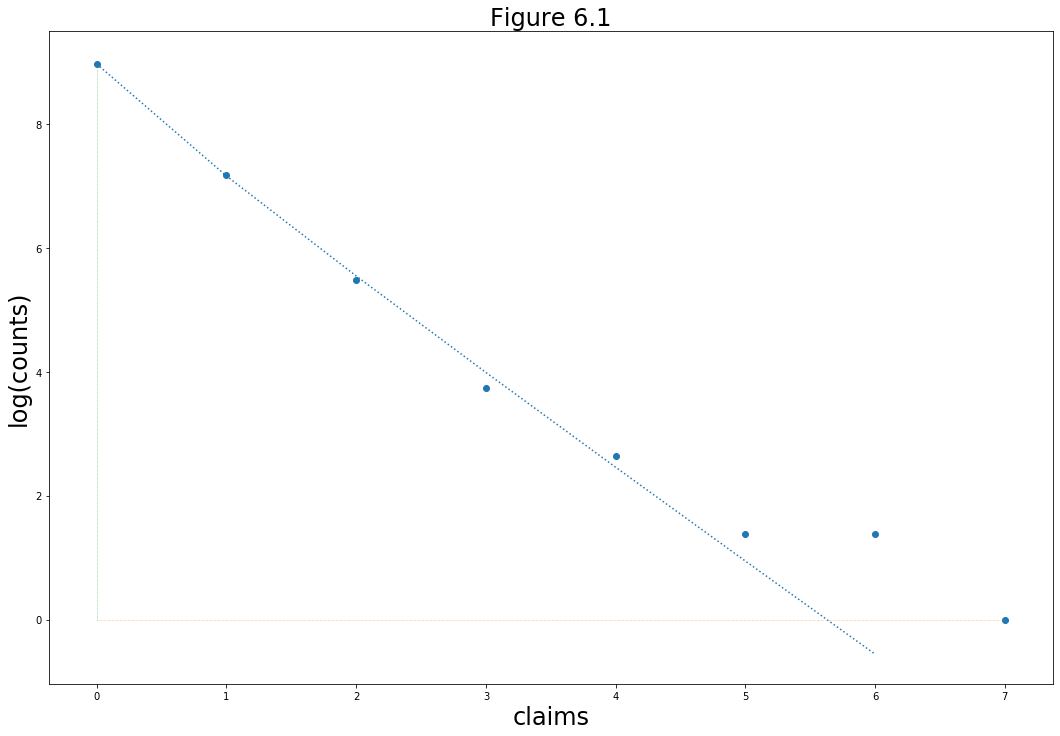

In [30]:
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));

# Define constants

# Plot
n_events = 0;
for claims, count in counts.items():
    n_events = n_events + count;

    

plt.plot(range(7), [log(n_events * f(x, nu, sigma)) for x in range(7)], ':', linewidth=1.5)
plt.scatter(range(8), [log(counts[x]) for x in range(8)])

Xzeros = np.linspace(0, 0, 7+1);
plt.plot(range(7+1), Xzeros, ':', linewidth=0.5);

Yzeros = np.linspace(0, 0, 8+2);
plt.plot(Yzeros, range(8+2), ':', linewidth=0.5);

# Display plots
plt.yscale('linear')
plt.xlabel('claims', fontsize=24);
plt.ylabel('log(counts)', fontsize=24);
plt.title('Figure 6.1', size=24);
#plt.legend(prop={'size': 18});
display(plt);

---
# 6.2 The Missing-Species Problem

### Setup

In [1]:
%matplotlib inline

In [3]:
#plt.rc("text", usetex=True)

Load data

In [5]:
butterflies = pd.read_csv("./data/butterfly.txt", delimiter=" ", index_col="x")

In [6]:
butterflies.head()

,y
x,
1,118
2,74
3,44
4,24
5,29


### Table 6.3

The formulas in 6.19 and 6.21:

In [10]:
def nonpar_bayes(butterflies, t):
    result = 0.0
    for n_times, row in butterflies.iterrows():
        n_butterflies = row["y"]
        result += (-1)**(n_times - 1) * n_butterflies * t**n_times
    return result

def sd_hat(butterflies, t):
    variance = 0.0
    for n_times, row in butterflies.iterrows():
        n_butterflies = row["y"]
        variance += n_butterflies * t**(2)
        # variance += n_butterflies * t**(2 * n_times)
    return np.sqrt(variance)

In [11]:
nonpar_vals = [nonpar_bayes(butterflies, i / 10) for i in range(11)]
sd_hat_vals = [sd_hat(butterflies, i / 10) for i in range(11)]

In [12]:
tmplt = "  {:>5.2f}" * 11
print("        t    0.0    0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9    1.0")
print("-" * 86)
print("     E(t)" + tmplt.format(*nonpar_vals))
print("sd_hat(t)" + tmplt.format(*sd_hat_vals))

        t    0.0    0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9    1.0
--------------------------------------------------------------------------------------
     E(t)   0.00  11.10  20.96  29.79  37.79  45.17  52.15  58.93  65.57  71.56  75.00
sd_hat(t)   0.00   2.24   4.48   6.71   8.95  11.19  13.43  15.67  17.91  20.14  22.38


The $\hat{sd}$ values here do not match table 6.3 from the book. If I change the exponent in the function `sd_hat()` from `2 * n_times` to just 2, then the values match:

In [9]:
def sd_hat_noexp(butterflies, t):
    variance = 0.0
    for n_times, row in butterflies.iterrows():
        n_butterflies = row["y"]
        variance += n_butterflies * t**2  # removed `* n_times`
    return np.sqrt(variance)

sd_hat_noexp_vals = [sd_hat_noexp(butterflies, i / 10) for i in range(11)]

print("sd_hat_noexp(t)" + tmplt.format(*sd_hat_noexp_vals))

sd_hat_noexp(t)   0.00   2.24   4.48   6.71   8.95  11.19  13.43  15.67  17.91  20.14  22.38


### Figure 6.2

In [10]:
# the plot's x values
t_vals = np.array([i / 10 for i in range(11)])

In [11]:
# the parametric empirical Bayes solution from pg 81

def par_bayes(butterflies, t):
    nu = 0.104
    sigma = 89.79
    gamma = sigma / (1 + sigma)
    return butterflies.loc[1, "y"] * (1 - (1 + gamma * t)**(-nu)) / (gamma * nu)

In [12]:
par_vals = [par_bayes(butterflies, t) for t in t_vals]

Create vertical standard deviation lines for the non-parametric empirical Bayes estimates

In [13]:
sd_lines = LineCollection(
    [
        [[t, exp - sd], [t, exp + sd]]
        for t, exp, sd in zip(t_vals, nonpar_vals, sd_hat_vals)
    ],
    color="k"
)

Make the plot

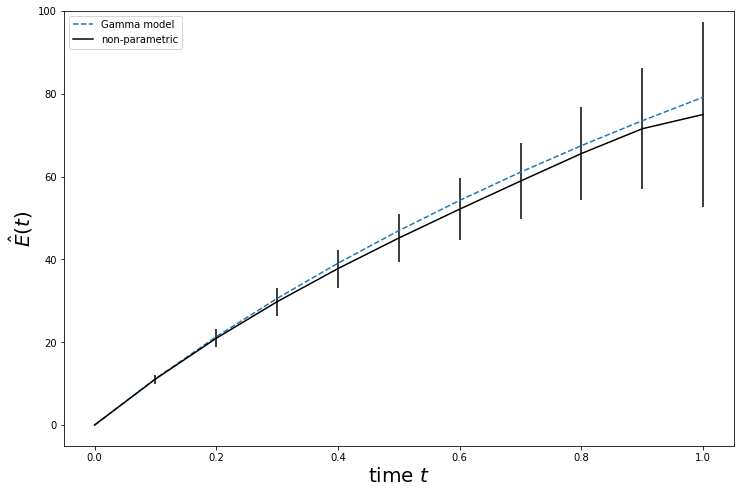

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(t_vals, par_vals, linestyle="--", label="Gamma model")
ax.plot(t_vals, nonpar_vals, c="k", label="non-parametric")
ax.add_collection(sd_lines)
ax.set_xlabel("time $t$", size=20)
ax.set_ylabel("$\hat{E}(t)$", size=20)
ax.set_ylim(-5, 100)
ax.legend(loc=2);

Calculate the Gamma model values beyond $t = 1$. In the book, these values are in the plot's legend.

In [15]:
print("t  E(t)")
print("-------")
for t in (2, 4, 8):
    n_exp = int(round(par_bayes(butterflies, t)))
    print("{}   {:>3}".format(t, n_exp))

t  E(t)
-------
2   123
4   176
8   233
